In [1]:
# %%
import numpy as np
import sys
import os

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=np.array([0.5, 0.1]),
    dt_base=0.002,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

🔍 Проверяем что новый код загружен...
👶 Создано 4 детей:
  0: forw_max с dt=0.1000, цвет=#FF6B6B
  1: back_max с dt=-0.1000, цвет=#9B59B6
  2: forw_min с dt=0.1000, цвет=#1ABC9C
  3: back_min с dt=-0.1000, цвет=#F39C12

🎨 Цвета детей:
  0: forw_max → цвет: #FF6B6B
  1: back_max → цвет: #9B59B6
  2: forw_min → цвет: #1ABC9C
  3: back_min → цвет: #F39C12

📊 Проверим что цвета разные:
Уникальные цвета: {'#F39C12', '#9B59B6', '#FF6B6B', '#1ABC9C'}
Всего цветов: 4

🎨 Новая визуализация:
🎨 ИСПРАВЛЕННАЯ версия visualize_spore_tree загружена!


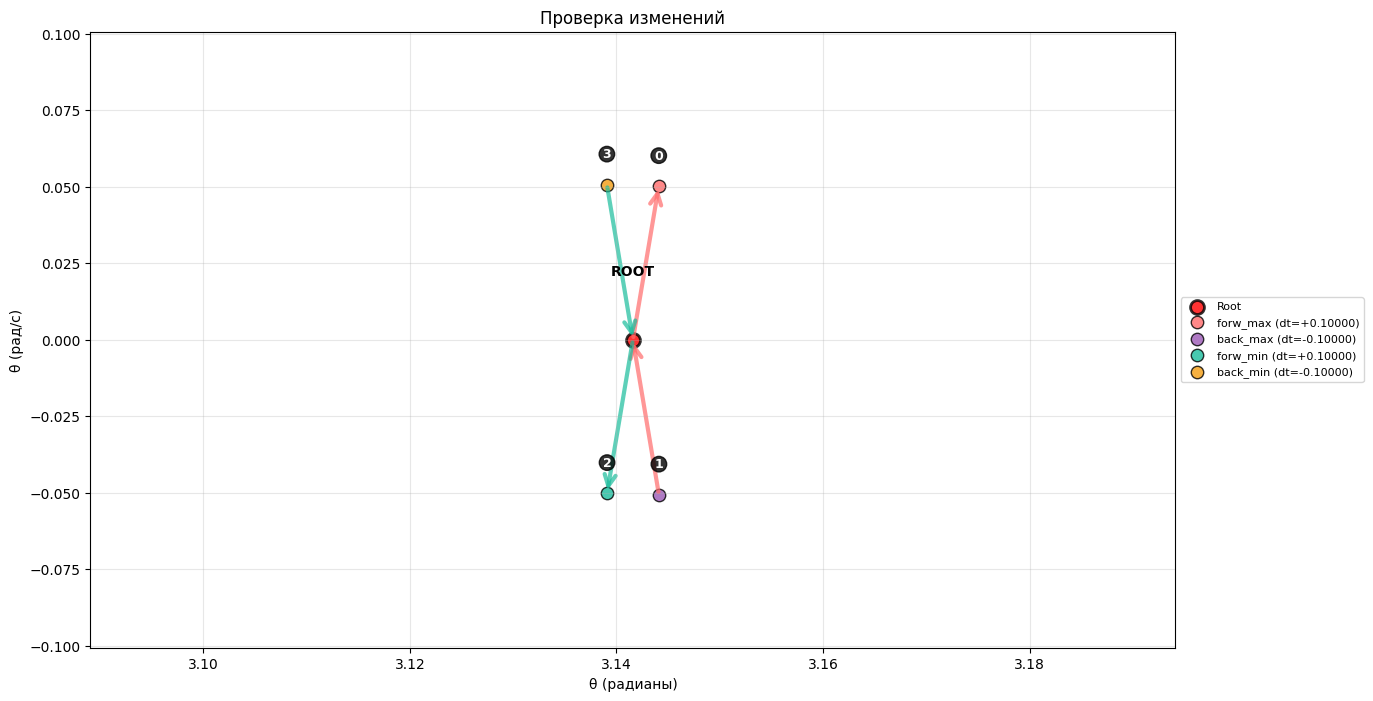

In [5]:
# Быстрый тест чтобы убедиться что изменения применились

print("🔍 Проверяем что новый код загружен...")

# Простой тест с большим dt 
config_test = SporeTreeConfig(dt_base=0.1, show_debug=False)
tree_test = SporeTree(pendulum, config_test)

# Создаем только детей для начала
children = tree_test.create_children(show=True)

print(f"\n🎨 Цвета детей:")
for i, child in enumerate(children):
    print(f"  {i}: {child['name']} → цвет: {child['color']}")

print(f"\n📊 Проверим что цвета разные:")
colors = [child['color'] for child in children]
print(f"Уникальные цвета: {set(colors)}")
print(f"Всего цветов: {len(set(colors))}")

# Визуализируем
print(f"\n🎨 Новая визуализация:")
visualize_spore_tree(tree_test, "Проверка изменений")

🔥 Экстремальный тест:
  dt_base: 0.2
  dt_grandchildren_factor: 0.5
👶 Создано 4 детей:
  0: forw_max с dt=0.2000, цвет=#FF6B6B
  1: back_max с dt=-0.2000, цвет=#9B59B6
  2: forw_min с dt=0.2000, цвет=#1ABC9C
  3: back_min с dt=-0.2000, цвет=#F39C12
👶 Создано 8 внуков:
  0: gc_0_0_max от родителя 0, dt=0.100000
  1: gc_0_1_min от родителя 0, dt=0.100000
  2: gc_1_0_max от родителя 1, dt=-0.100000
  3: gc_1_1_min от родителя 1, dt=-0.100000
  4: gc_2_0_max от родителя 2, dt=0.100000
  5: gc_2_1_min от родителя 2, dt=0.100000
  6: gc_3_0_max от родителя 3, dt=-0.100000
  7: gc_3_1_min от родителя 3, dt=-0.100000

📏 Расстояния детей от корня:
  0: forw_max → 0.103
  1: back_max → 0.105
  2: forw_min → 0.103
  3: back_min → 0.105

📏 Расстояния внуков от родителей:
  0: gc_0_0_max → 0.0581
  1: gc_0_1_min → 0.0444
  2: gc_1_0_max → 0.0609
  3: gc_1_1_min → 0.0428
  4: gc_2_0_max → 0.0444
  5: gc_2_1_min → 0.0581
  6: gc_3_0_max → 0.0428
  7: gc_3_1_min → 0.0609

🎨 Визуализация:
🎨 ИСПРАВЛЕННА

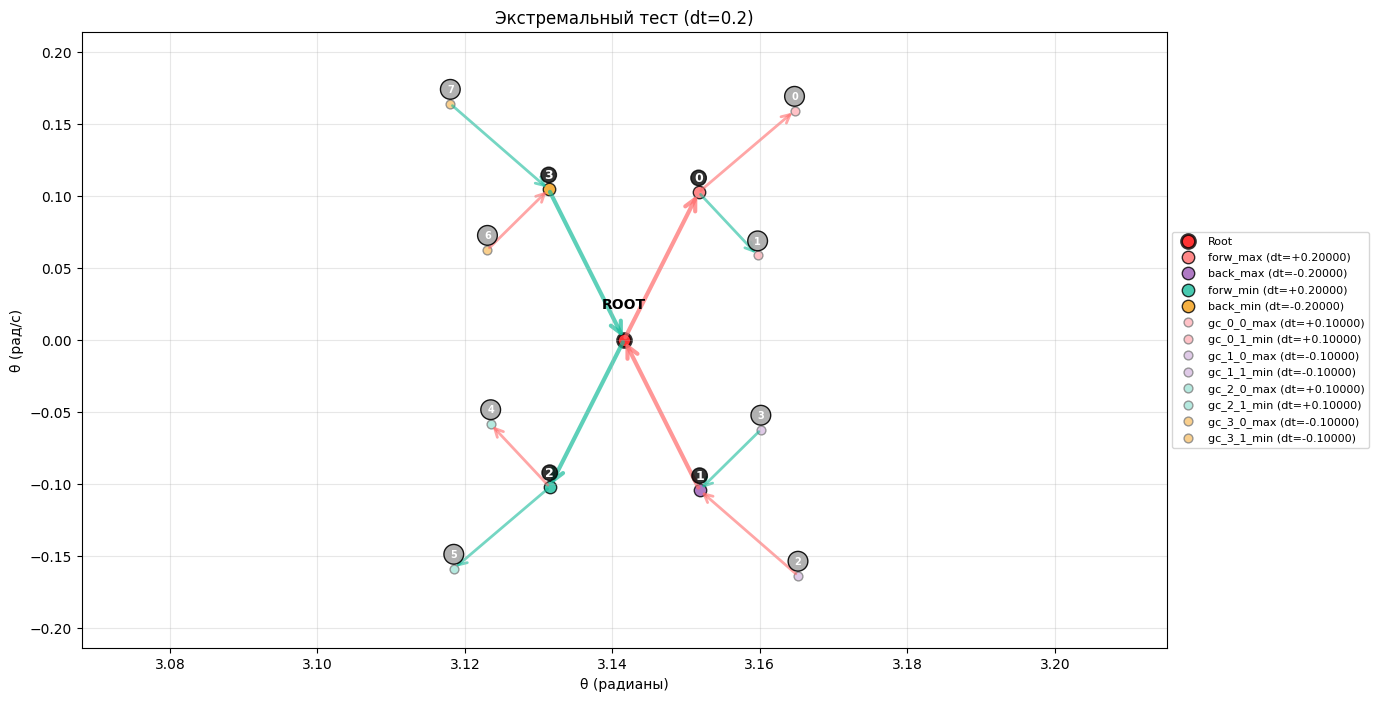

In [6]:
# Экстремальный тест для максимальной видимости различий

# Очень большой dt для наглядности
config_extreme = SporeTreeConfig(
    initial_position=np.array([np.pi, 0.0]),
    dt_base=0.2,  # Очень большой шаг!
    dt_grandchildren_factor=0.5,  # Внуки в 2 раза меньше 
    show_debug=False
)

print("🔥 Экстремальный тест:")
print(f"  dt_base: {config_extreme.dt_base}")
print(f"  dt_grandchildren_factor: {config_extreme.dt_grandchildren_factor}")

# Создаем дерево
tree_extreme = SporeTree(pendulum, config_extreme)

# Создаем всю структуру
children = tree_extreme.create_children(show=True)
grandchildren = tree_extreme.create_grandchildren(show=True)

print(f"\n📏 Расстояния детей от корня:")
for i, child in enumerate(children):
    distance = np.linalg.norm(child['position'] - tree_extreme.root['position'])
    print(f"  {i}: {child['name']} → {distance:.3f}")

print(f"\n📏 Расстояния внуков от родителей:")
for gc in grandchildren:
    parent = tree_extreme.children[gc['parent_idx']]
    distance = np.linalg.norm(gc['position'] - parent['position'])
    print(f"  {gc['global_idx']}: {gc['name']} → {distance:.4f}")

print(f"\n🎨 Визуализация:")
visualize_spore_tree(tree_extreme, "Экстремальный тест (dt=0.2)")

👶 Создано 4 детей:
  0: forw_max с dt=0.1000, цвет=#FF6B6B
  1: back_max с dt=-0.1000, цвет=#9B59B6
  2: forw_min с dt=0.1000, цвет=#1ABC9C
  3: back_min с dt=-0.1000, цвет=#F39C12

✅ Проверка класса SporeTree:
Количество детей: 4
Цвета детей: ['#FF6B6B', '#9B59B6', '#1ABC9C', '#F39C12']
Имена детей: ['forw_max', 'back_max', 'forw_min', 'back_min']

✅ Тест функции визуализации:
Если видите принт 'Новая версия загружена' - функция обновилась
Если НЕ видите принт - функция старая
🎨 ИСПРАВЛЕННАЯ версия visualize_spore_tree загружена!


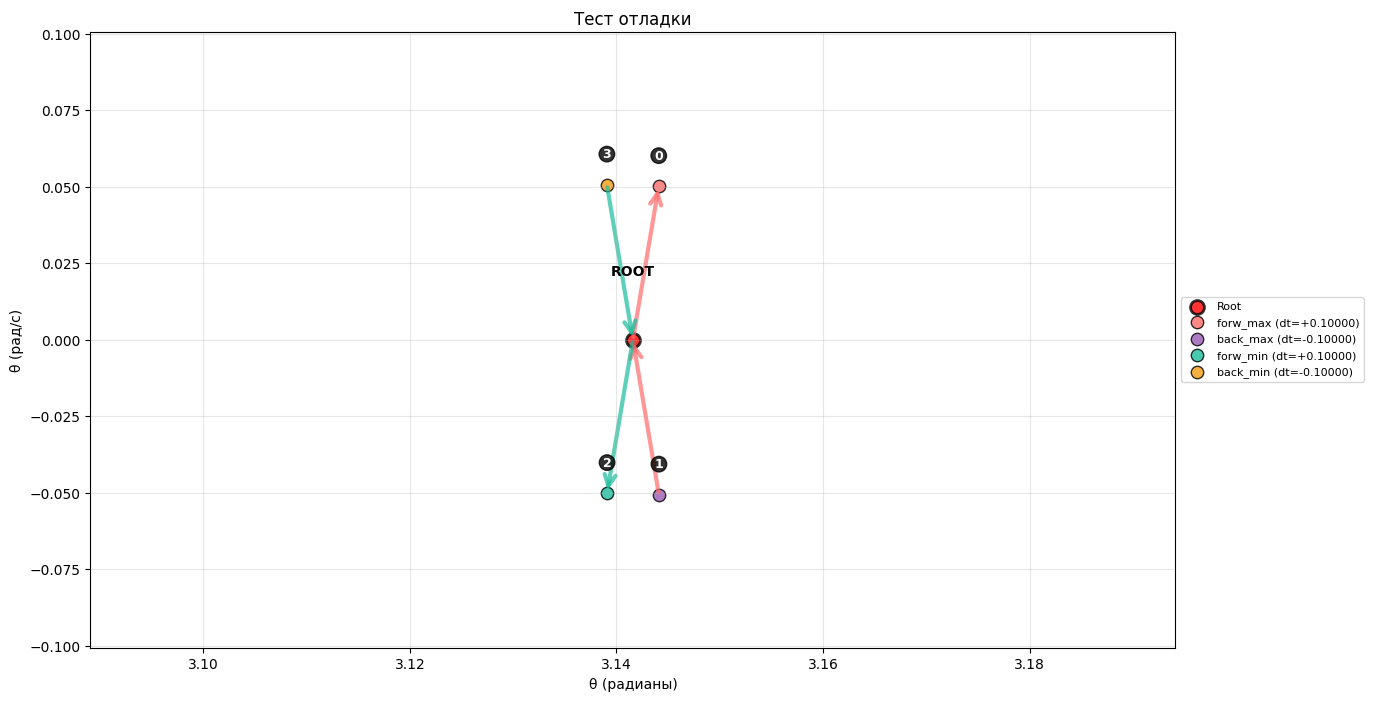


📋 Что должно быть в новой версии:
1. Принт '🎨 Новая версия visualize_spore_tree загружена!'
2. БЕЗ аннотаций на ребрах (старая версия их показывает)
3. Легенда СПРАВА от графика
4. Пунктирные стрелки для backward (dt < 0)


In [7]:
# Отладочный тест для проверки что работает

config_debug = SporeTreeConfig(dt_base=0.1, show_debug=False)
tree_debug = SporeTree(pendulum, config_debug)

# Создаем только детей
children = tree_debug.create_children(show=True)

print(f"\n✅ Проверка класса SporeTree:")
print(f"Количество детей: {len(children)}")
print(f"Цвета детей: {[child['color'] for child in children]}")
print(f"Имена детей: {[child['name'] for child in children]}")

print(f"\n✅ Тест функции визуализации:")
print("Если видите принт 'Новая версия загружена' - функция обновилась")
print("Если НЕ видите принт - функция старая")

try:
    # Этот вызов покажет загрузилась ли новая функция
    visualize_spore_tree(tree_debug, "Тест отладки")
except Exception as e:
    print(f"❌ Ошибка визуализации: {e}")

print(f"\n📋 Что должно быть в новой версии:")
print(f"1. Принт '🎨 Новая версия visualize_spore_tree загружена!'")
print(f"2. БЕЗ аннотаций на ребрах (старая версия их показывает)")
print(f"3. Легенда СПРАВА от графика")
print(f"4. Пунктирные стрелки для backward (dt < 0)")